In [ ]:
import os
os._exit(00)  # force kernel restart

In [ ]:
#CNN Encoder

In [1]:
import os
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Encoder

class CNNEncoder(nn.Module):
    def __init__(self, in_channels=60, time_len=564, emb_dim=128, pool_T=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(),
            #nn.AdaptiveAvgPool1d(pool_T)
        )

    def forward(self, x):  # x: (B, C, T)
        return self.encoder(x)  # (B, emb_dim, pool_T)

In [3]:
#Pretrain Pipeline

class MAEDecoder(nn.Module):
    def __init__(self, emb_dim=128, out_channels=60, out_time=564):
        super().__init__()
        #self.decoder = nn.Sequential(
           # nn.Conv1d(emb_dim, 256, kernel_size=3, padding=1),
           # nn.ReLU(),
           # nn.Conv1d(256, 128, kernel_size=3, padding=1),
           # nn.ReLU(),
           # nn.Conv1d(128, out_channels, kernel_size=3, padding=1),
           # nn.Upsample(size=out_time, mode="linear", align_corners=True)
        #)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(emb_dim, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.Conv1d(64, out_channels, kernel_size=3, padding=1),
            nn.Upsample(size=564, mode='linear', align_corners=True)
        )


    def forward(self, x):  # x: (B, emb_dim, T)
        return self.decoder(x)  # Output: (B, C, T=564)

# ---- Projection head for SimCLR ----
class ProjectionHead(nn.Module):
    def __init__(self, emb_dim=128, proj_dim=64):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, proj_dim)
        )

    #def forward(self, x):  # x: (B, T, emb_dim)
    #    x = x.mean(dim=1)  # Global average pooling
    #    return self.proj(x)

    def forward(self, x):  # x: (B, emb_dim, T)
        x = x.permute(0, 2, 1)  # → (B, T, emb_dim)
        x = x.mean(dim=1)       # → (B, emb_dim)
        return self.proj(x)

# ---- Contrastive Loss ----
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        batch_size = z1.size(0)
        z = torch.cat([z1, z2], dim=0)
        z = F.normalize(z, dim=1)
        similarity_matrix = torch.matmul(z, z.T)
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        mask = (~torch.eye(2 * batch_size, dtype=torch.bool)).to(z.device)
        negatives = similarity_matrix[mask].view(2 * batch_size, -1)
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        logits /= self.temperature
        labels = torch.zeros(2 * batch_size, dtype=torch.long).to(z.device)
        return F.cross_entropy(logits, labels)

# ---- Full Hybrid Pretraining Model ----
class PretrainingModel(nn.Module):
    def __init__(self, encoder, emb_dim=128, out_channels=60):
        super().__init__()
        self.encoder = encoder
        self.decoder = MAEDecoder(emb_dim, out_channels)
        self.projector = ProjectionHead(emb_dim)

    def forward(self, x_masked, x_aug1, x_aug2):
        z_masked = self.encoder(x_masked)      # (B, emb_dim, T)
        recon = self.decoder(z_masked)         # (B, C, T)

        z1 = self.encoder(x_aug1)
        z2 = self.encoder(x_aug2)
        p1 = self.projector(z1)
        p2 = self.projector(z2)

        return recon, p1, p2

# ---- Training Loop ----
def train_pretrain(model, dataloader, epochs=40, lr=3e-3, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    contrastive_criterion = NTXentLoss()
    loss_history = []

    recon_loss_history = []
    contrast_loss_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        recon_loss_total = 0
        contrast_loss_total = 0
        
        for batch in dataloader:
            x = batch['original'].to(device)
            x_masked = batch['masked'].to(device)
            x1 = batch['aug1'].to(device)
            x2 = batch['aug2'].to(device)

            recon, p1, p2 = model(x_masked, x1, x2)
            
            loss_recon = F.mse_loss(recon, x)
            loss_contrast = contrastive_criterion(p1, p2)
                        
            # Temporarily disable contrastive loss
            #loss = loss_recon
            
            loss = loss_recon + 0.02*loss_contrast  # <-- Weighting, since contrastive loss dominates

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            recon_loss_total += loss_recon.item()
            contrast_loss_total += loss_contrast.item()

        #print("MSE per channel:", F.mse_loss(recon, x, reduction='none').mean(dim=(0, 2)))

        #print("Recon shape:", recon.shape, "Original shape:", x.shape)

        avg_loss = total_loss / len(dataloader)

        avg_recon_loss = recon_loss_total / len(dataloader)
        avg_contrast_loss = contrast_loss_total / len(dataloader)
        
        loss_history.append(avg_loss)

        recon_loss_history.append(avg_recon_loss)
        contrast_loss_history.append(avg_contrast_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Total: {loss.item():.4f}, Recon: {loss_recon.item():.4f}, Contrast: {loss_contrast.item():.4f}")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(x[0][0].cpu().numpy(), label='original')
    plt.plot(recon[0][0].detach().cpu().numpy(), label='reconstructed')
    plt.title("Original vs. Reconstructed Signal from the first channel of the first sample", fontsize=10)
    plt.legend(); plt.show()
    
    return model, loss_history, recon_loss_history, contrast_loss_history

In [61]:
#Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, mask_ratio=0.15, augment=True):
        self.data = []
        self.labels = []
        self.mask_ratio = mask_ratio
        self.augment = augment

        for file in os.listdir(data_folder):
            if file.endswith(".npz"):
                loaded = np.load(os.path.join(data_folder, file))
                X = loaded['X']  # Shape: (n_epochs, n_channels, n_times)
                y = loaded['y']  # Shape: (n_epochs,)
                self.data.append(torch.tensor(X, dtype=torch.float32))
                self.labels.append(torch.tensor(y, dtype=torch.long))

        self.data = torch.cat(self.data, dim=0)
        self.labels = torch.cat(self.labels, dim=0)
        self.n_channels = self.data.shape[1]
        self.n_times = self.data.shape[2]

    def __len__(self):
        return len(self.data)

    def mask_signal(self, x):
        masked = x.clone()
        patch_size = 40
        num_patches = x.shape[-1] // patch_size
        mask_indices = random.sample(range(num_patches), int(self.mask_ratio * num_patches))
        for idx in mask_indices:
            masked[:, idx * patch_size:(idx + 1) * patch_size] = 0
            
        if random.random() < 0.3:
            channel = random.randint(0, x.shape[0] - 1)
            masked[channel, :] = 0
            
        return masked

    def augment_signal(self, x):
        x_aug = x.clone()
        if random.random() < 0.7:
            x_aug += 0.01 * torch.randn_like(x)  # Jittering
        if random.random() < 0.5:
            scale = 0.95 + 0.1 * torch.rand(x.shape[0], 1)
            x_aug *= scale                     # Channel-wise scaling
        if random.random() < 0.5:
            x_aug = torch.flip(x_aug, dims=[-1])  # Time reversal
        if random.random() < 0.3:
            shift = random.randint(0, x.shape[-1] // 10)
            x_aug = torch.roll(x_aug, shifts=shift, dims=-1)  # Time shifting
        return x_aug

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        x_masked = self.mask_signal(x)
        x1 = self.augment_signal(x)
        x2 = self.augment_signal(x)

        return {
            'original': x,
            'masked': x_masked,
            'aug1': x1,
            'aug2': x2,
            'label': y
        }
        

def get_loader(data_folder, batch_size=32, shuffle=True):
    dataset = EEGDataset(data_folder)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

In [43]:
class EEGData:
    def __init__(self, data_folder, mask_ratio=0.15, augment=True):
        self.data = []
        self.labels = []
        self.mask_ratio = mask_ratio
        self.augment = augment

        for file in os.listdir(data_folder):
            if file.endswith(".npz"):
                loaded = np.load(os.path.join(data_folder, file))
                X = loaded['X']  # Shape: (n_epochs, n_channels, n_times)
                y = loaded['y']  # Shape: (n_epochs,)
                self.data.append(torch.tensor(X, dtype=torch.float32))
                self.labels.append(torch.tensor(y, dtype=torch.long))

        self.data = torch.cat(self.data, dim=0)
        self.labels = torch.cat(self.labels, dim=0)

        self.n_epochs = self.data.shape[0]
        self.n_channels = self.data.shape[1]
        self.n_times = self.data.shape[2]

        print(f"Number of epochs   : {self.n_epochs}")
        print(f"Number of channels : {self.n_channels}")
        print(f"Number of time steps: {self.n_times}")


In [44]:
dataset = EEGData("preprocessed_epochs")

Number of epochs   : 6538
Number of channels : 60
Number of time steps: 564


Epoch 1/40, Total: 0.2690, Recon: 0.2405, Contrast: 1.4277
Epoch 1/40, Loss: 0.3730
Epoch 2/40, Total: 0.2194, Recon: 0.1908, Contrast: 1.4310
Epoch 2/40, Loss: 0.2877
Epoch 3/40, Total: 0.2435, Recon: 0.2152, Contrast: 1.4172
Epoch 3/40, Loss: 0.2628
Epoch 4/40, Total: 0.2405, Recon: 0.2121, Contrast: 1.4240
Epoch 4/40, Loss: 0.2480
Epoch 5/40, Total: 0.1978, Recon: 0.1692, Contrast: 1.4277
Epoch 5/40, Loss: 0.2393
Epoch 6/40, Total: 0.2123, Recon: 0.1840, Contrast: 1.4108
Epoch 6/40, Loss: 0.2342
Epoch 7/40, Total: 0.2272, Recon: 0.1988, Contrast: 1.4183
Epoch 7/40, Loss: 0.2308
Epoch 8/40, Total: 0.2141, Recon: 0.1860, Contrast: 1.4059
Epoch 8/40, Loss: 0.2257
Epoch 9/40, Total: 0.1934, Recon: 0.1656, Contrast: 1.3944
Epoch 9/40, Loss: 0.2246
Epoch 10/40, Total: 0.1993, Recon: 0.1713, Contrast: 1.3972
Epoch 10/40, Loss: 0.2193
Epoch 11/40, Total: 0.2165, Recon: 0.1886, Contrast: 1.3953
Epoch 11/40, Loss: 0.2171
Epoch 12/40, Total: 0.1985, Recon: 0.1700, Contrast: 1.4237
Epoch 12/40,

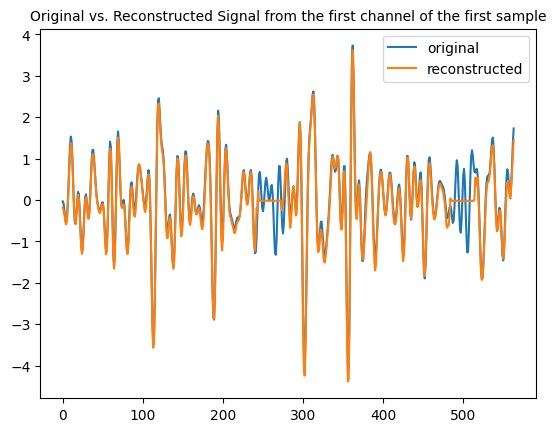

Model saved to cnn_encoder_output


In [70]:
#Training
if __name__ == "__main__":
    data_path = "preprocessed_epochs"  
    save_path = "cnn_encoder_output"
    os.makedirs(save_path, exist_ok=True)

    # Load dataset
    loader = get_loader(data_path)

    # Initialize CNN encoder
    encoder = CNNEncoder(in_channels=60, time_len=564)

    #Build full model
    model = PretrainingModel(encoder, emb_dim=128, out_channels=60)

    # Train with MAE + contrastive pretraining
    model, loss_history, recon_loss_history, contrast_loss_history = train_pretrain(
        model=model,
        dataloader=loader,
        epochs=40,
        lr=3e-3,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Save model
    torch.save(model.state_dict(), os.path.join(save_path, "pretrained_model.pth"))
    print("Model saved to", save_path)


In [49]:
def custom_collate_fn(batch):
    batch_dict = {}
    for key in batch[0]:
        if key == 'label':
            batch_dict[key] = torch.tensor([sample[key] for sample in batch])
        else:
            batch_dict[key] = torch.stack([sample[key] for sample in batch])
    return batch_dict


In [50]:
def get_loader(data_folder, batch_size=32, shuffle=True):
    dataset = EEGDataset(data_folder)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=2, pin_memory=True, collate_fn=custom_collate_fn)


In [62]:
loader = get_loader(data_path)

In [65]:
def visualize_pretrain_recon(model, dataloader, device='cuda', num_examples=3):
    model.eval()
    batch = next(iter(dataloader))  # Already a dict

    x_true = batch['original'].to(device)
    x_masked = batch['masked'].to(device)
    x_aug1 = batch['aug1'].to(device)
    x_aug2 = batch['aug2'].to(device)

    with torch.no_grad():
        recon, _, _ = model(x_masked, x_aug1, x_aug2)

    x_true = x_true.cpu().numpy()
    x_masked = x_masked.cpu().numpy()
    recon = recon.cpu().numpy()

    for i in range(min(num_examples, x_true.shape[0])):
        ch = np.random.randint(0, x_true.shape[1])
        t = np.arange(x_true.shape[2])

        plt.figure(figsize=(14, 4))
        plt.plot(t, x_true[i][ch], label='Original', color='blue')
        plt.plot(t, x_masked[i][ch], label='Masked', color='red', alpha=0.4)
        plt.plot(t, recon[i][ch], label='Reconstructed', color='green', linestyle='--')
        plt.title(f"EEG Signal - Example {i+1} | Channel {ch}")
        plt.xlabel("Time"); plt.ylabel("Amplitude")
        plt.legend(); plt.tight_layout()
        plt.show()


In [67]:
# Rebuild your pretraining model
encoder = CNNEncoder(in_channels=60, time_len=564)
model = PretrainingModel(encoder, emb_dim=128, out_channels=60)
model.load_state_dict(torch.load("cnn_encoder_output/pretrained_model.pth"))  # if needed
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


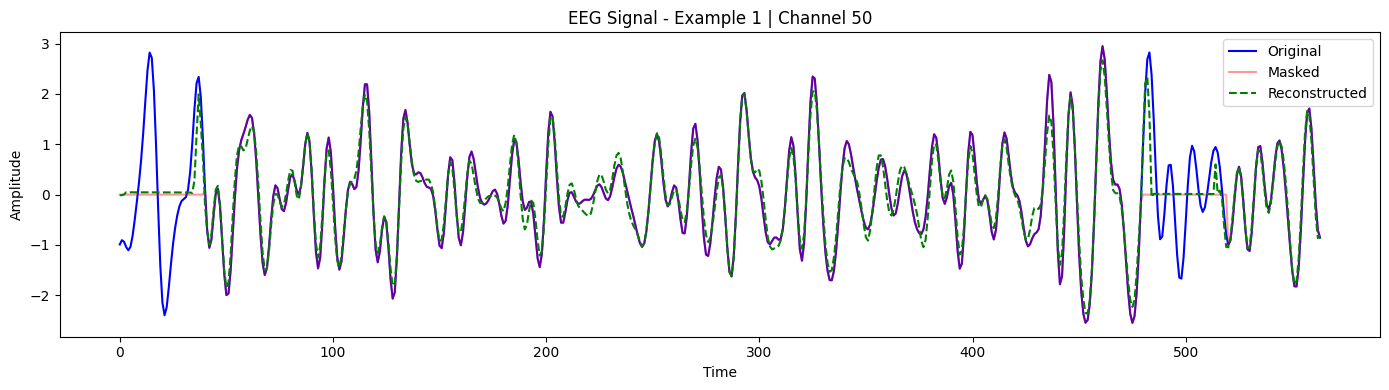

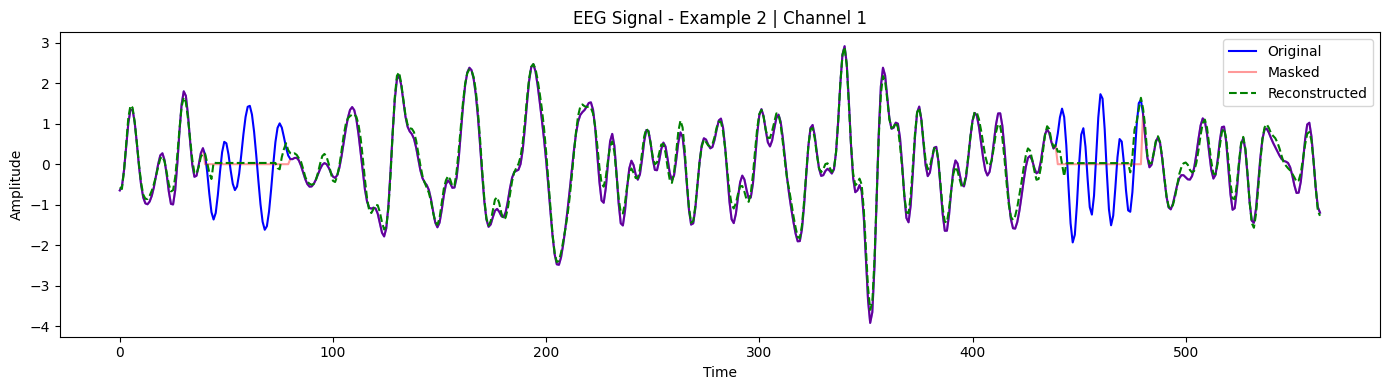

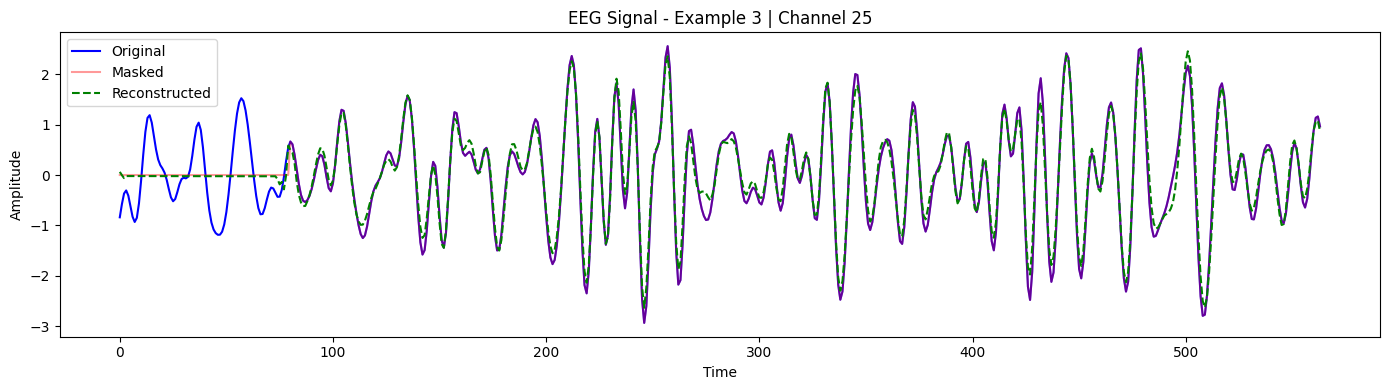

In [68]:
visualize_pretrain_recon(model, loader, device='cuda' if torch.cuda.is_available() else 'cpu')

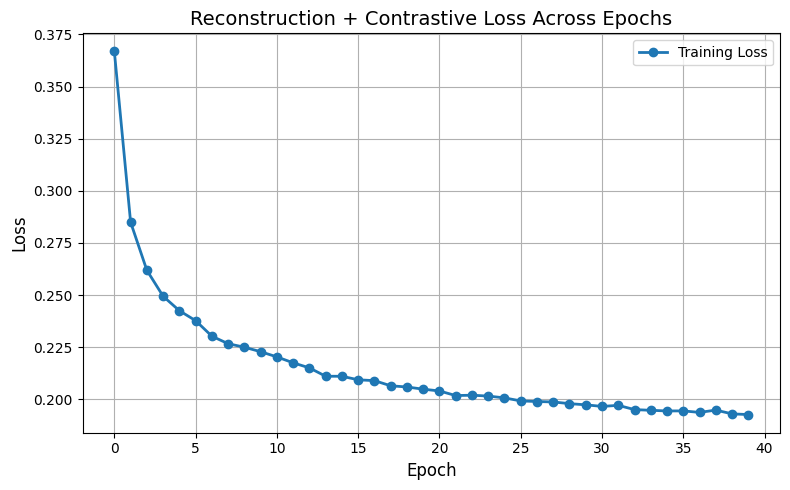

In [6]:
#Plot training loss across epochs

plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o', linewidth=2, label='Training Loss')
plt.title("Reconstruction + Contrastive Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

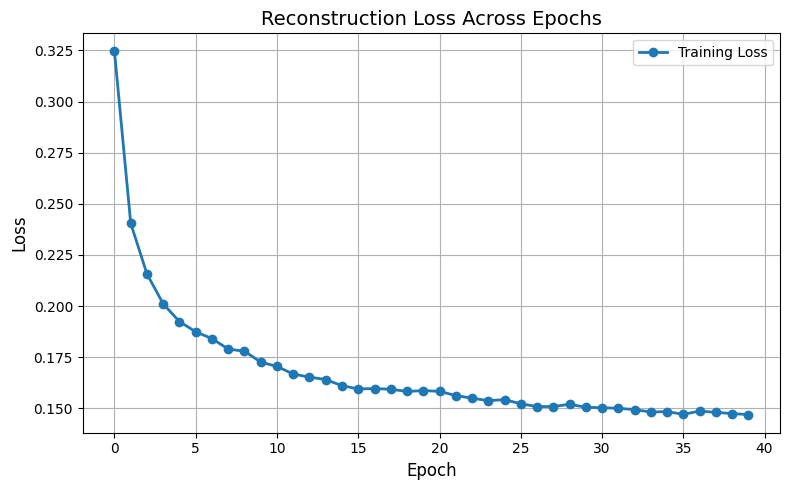

In [71]:
#Reconstruction loss over epochs

plt.figure(figsize=(8, 5))
plt.plot(recon_loss_history, marker='o', linewidth=2, label='Training Loss')
plt.title("Reconstruction Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

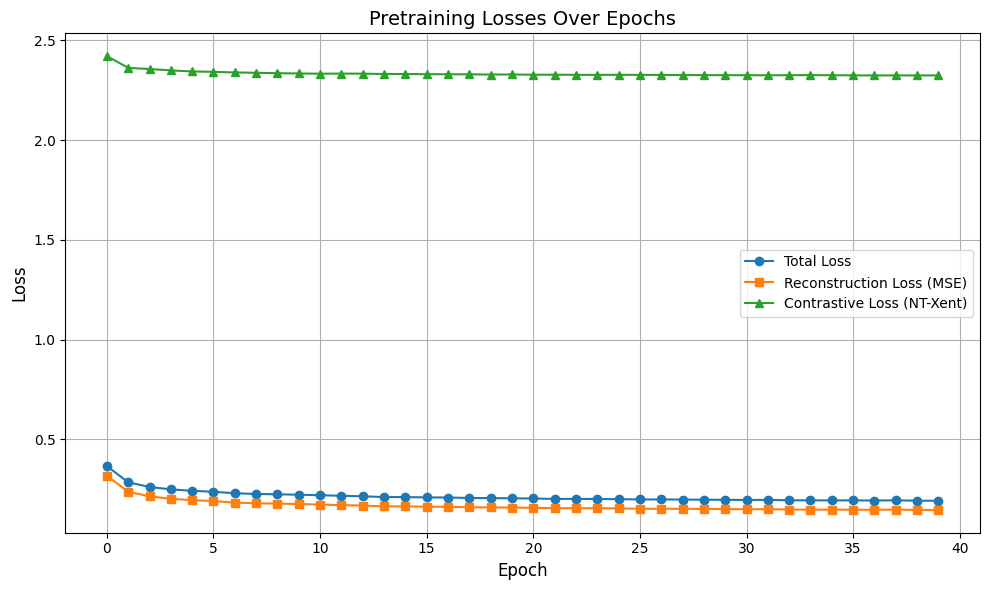

In [7]:
#Plot all three losses

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss', marker='o')
plt.plot(recon_loss_history, label='Reconstruction Loss (MSE)', marker='s')
plt.plot(contrast_loss_history, label='Contrastive Loss (NT-Xent)', marker='^')
plt.title("Pretraining Losses Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import numpy as np

file = 'preprocessed_epochs/session1_sub1_twist_MI.npz'
data = np.load(file)
print(data.files)  # Should show: ['X', 'y']

['X', 'y']


In [6]:
#Evaluate Pretrained Encoder with a Classification Head

# --- Dataset for labeled EEG ---
class EEGClassificationDataset(Dataset):
    def __init__(self, data_folder):
        self.X, self.y = [], []
        for file in os.listdir(data_folder):
            if file.endswith(".npz"):
                data = np.load(os.path.join(data_folder, file))
                self.X.append(torch.tensor(data['X'], dtype=torch.float32))
                self.y.append(torch.tensor(data['y'], dtype=torch.long))
        self.X = torch.cat(self.X, dim=0)
        self.y = torch.cat(self.y, dim=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Small MLP classifier on frozen encoder features ---
class ClassificationHead(nn.Module):
    def __init__(self, emb_dim=128, n_classes=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):  # x: (B, emb_dim, T)
        x = x.mean(dim=-1)  # Global average pooling
        return self.fc(x)

# --- Evaluation ---
def evaluate_encoder_with_classifier(encoder, data_path, n_classes=2):
    dataset = EEGClassificationDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False

    clf = ClassificationHead(n_classes=n_classes).to('cuda')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):  #can increase
        clf.train()
        total_loss = 0
        correct = 0
        for x, y in dataloader:
            x, y = x.to('cuda'), y.to('cuda')
            with torch.no_grad():
                features = encoder(x)  # (B, emb_dim, T)
            out = clf(features)
            loss = loss_fn(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        acc = correct / len(dataset)
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate_encoder(encoder, dataloader, device='cuda'):
    encoder.eval()
    features = []
    labels = []

    for batch in dataloader:
        x = batch['original'].to(device)  # (B, C, T)
        label = batch.get('label', torch.zeros(x.size(0))).long()  # Dummy labels unless you have them

        with torch.no_grad():
            z = encoder(x)  # (B, emb_dim, T)
            z = z.mean(dim=2)  # Global average pooling → (B, emb_dim)

        features.append(z.cpu())
        labels.append(label)

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Dummy labels = 0 if real labels not present
    if len(set(labels)) == 1:
        print("⚠️ No ground-truth labels available — skipping evaluation.")
        return 0.0

    clf = LogisticRegression(max_iter=1000)
    clf.fit(features, labels)
    preds = clf.predict(features)
    return accuracy_score(labels, preds) * 100


In [8]:
#Visualize Encoder Representations with t-SNE

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_representations(encoder, data_path):
    dataset = EEGClassificationDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    encoder.eval()
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to('cuda')
            features = encoder(x).mean(dim=-1).cpu().numpy()  # (B, emb_dim)
            all_feats.append(features)
            all_labels.append(y.numpy())

    X = np.concatenate(all_feats)
    y = np.concatenate(all_labels)

    X_std = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_std)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="Set2")
    plt.title("t-SNE of Encoder Representations")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.show()


✅ Pretrained encoder loaded successfully!

🔍 Evaluating encoder with classification head...
[Epoch 1] Loss: 142.2802, Accuracy: 0.5106
[Epoch 2] Loss: 142.1708, Accuracy: 0.4960
[Epoch 3] Loss: 142.1544, Accuracy: 0.4942
[Epoch 4] Loss: 142.1656, Accuracy: 0.4954
[Epoch 5] Loss: 142.0999, Accuracy: 0.5046
[Epoch 6] Loss: 142.1424, Accuracy: 0.5000
[Epoch 7] Loss: 142.1114, Accuracy: 0.5034
[Epoch 8] Loss: 142.1279, Accuracy: 0.4991
[Epoch 9] Loss: 142.1167, Accuracy: 0.4962
[Epoch 10] Loss: 142.1239, Accuracy: 0.4991

🎨 Visualizing encoder feature space...


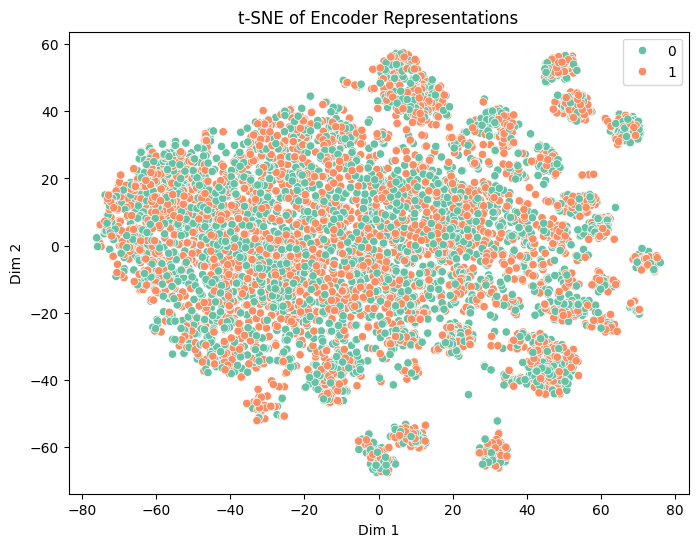


🧪 Linear evaluation accuracy: 52.43%


In [9]:
def main():
    
    # --- Paths ---
    data_path = "preprocessed_epochs"  
    model_path = "cnn_encoder_output/pretrained_model.pth"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset = EEGDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # --- Load full checkpoint ---
    checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    # --- Extract encoder weights only ---
    encoder_state = {k.replace('encoder.', ''): v for k, v in checkpoint.items() if k.startswith('encoder.')}
    encoder = CNNEncoder(in_channels=60, time_len=564)
    #encoder.load_state_dict(encoder_state)
    
    # Extract the internal CNN weights only (no prefix in keys)
    cnn_weights = {k: v for k, v in checkpoint.items() if k.startswith("encoder.encoder.")}
    cnn_weights = {k.replace("encoder.encoder.", ""): v for k, v in cnn_weights.items()}

    # Load them into encoder.encoder (the nn.Sequential block)
    encoder.encoder.load_state_dict(cnn_weights)
    
    encoder = encoder.to('cuda' if torch.cuda.is_available() else 'cpu')

    print("✅ Pretrained encoder loaded successfully!")

    #Evaluate with classification head ---
    print("\n🔍 Evaluating encoder with classification head...")
    evaluate_encoder_with_classifier(encoder, data_path, n_classes=2)

    #Visualize representations using t-SNE ---
    print("\n🎨 Visualizing encoder feature space...")
    visualize_representations(encoder, data_path)

    accuracy = evaluate_encoder(encoder, dataloader, device)
    print(f"\n🧪 Linear evaluation accuracy: {accuracy:.2f}%")


if __name__ == "__main__":
    main()


In [9]:
data = np.load('preprocessed_epochs/session1_sub1_twist_MI.npz')
print(np.bincount(data['y']))

[49 50]


In [10]:
#Evaluation pipeline with finetuning

class EEGFinetuneClassifier(nn.Module):
    def __init__(self, encoder, emb_dim=128, n_classes=2):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        z = self.encoder(x)  # (B, emb_dim, T)
        return self.classifier(z)


In [11]:
#Training loop

def finetune_encoder(encoder, data_path, n_classes=2, lr=1e-3, epochs=10):
    dataset = EEGClassificationDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = EEGFinetuneClassifier(encoder, emb_dim=128, n_classes=n_classes).to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for x, y in dataloader:
            x, y = x.to('cuda'), y.to('cuda')
            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()

        acc = correct / len(dataset)
        print(f"[Fine-tune Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


✅ Pretrained encoder loaded successfully!

🔍 Evaluating fine-tuned encoder...
[Fine-tune Epoch 1] Loss: 142.4006, Accuracy: 0.4979
[Fine-tune Epoch 2] Loss: 142.1722, Accuracy: 0.5026
[Fine-tune Epoch 3] Loss: 142.0822, Accuracy: 0.5096
[Fine-tune Epoch 4] Loss: 142.0917, Accuracy: 0.5018
[Fine-tune Epoch 5] Loss: 142.0742, Accuracy: 0.5153
[Fine-tune Epoch 6] Loss: 141.8399, Accuracy: 0.5165
[Fine-tune Epoch 7] Loss: 141.5752, Accuracy: 0.5362
[Fine-tune Epoch 8] Loss: 141.2937, Accuracy: 0.5338
[Fine-tune Epoch 9] Loss: 140.3822, Accuracy: 0.5571
[Fine-tune Epoch 10] Loss: 139.5912, Accuracy: 0.5650

🎨 Visualizing encoder feature space...


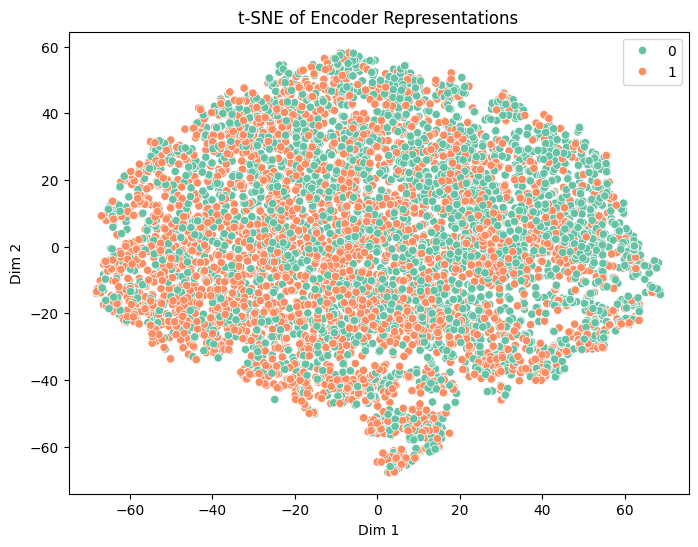


🧪 Linear evaluation accuracy: 61.46%


In [20]:
def main():
    # --- Paths ---
    data_path = "preprocessed_epochs"  
    model_path = "cnn_encoder_output/pretrained_model.pth"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # --- Load full checkpoint ---
    checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    # --- Extract encoder weights only ---
    encoder_state = {k.replace('encoder.', ''): v for k, v in checkpoint.items() if k.startswith('encoder.')}
    encoder = CNNEncoder(in_channels=60, time_len=564)
    #encoder.load_state_dict(encoder_state)
    
    # Extract the internal CNN weights only (no prefix in keys)
    cnn_weights = {k: v for k, v in checkpoint.items() if k.startswith("encoder.encoder.")}
    cnn_weights = {k.replace("encoder.encoder.", ""): v for k, v in cnn_weights.items()}

    # Load them into encoder.encoder (the nn.Sequential block)
    encoder.encoder.load_state_dict(cnn_weights)
    
    encoder = encoder.to('cuda' if torch.cuda.is_available() else 'cpu')

    print("✅ Pretrained encoder loaded successfully!")

    dataset = EEGDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # --- Step (1): Evaluate with classification head ---
    print("\n🔍 Evaluating fine-tuned encoder...")
    finetune_encoder(encoder, data_path, n_classes=2)

    # --- Step (2): Visualize representations using t-SNE ---
    print("\n🎨 Visualizing encoder feature space...")
    visualize_representations(encoder, data_path)

    accuracy = evaluate_encoder(encoder, dataloader, device)
    print(f"\n🧪 Linear evaluation accuracy: {accuracy:.2f}%")

if __name__ == "__main__":
    main()

In [12]:
#SimSiam Architecture for EEG

# Shared encoder (CNNEncoder)
# Projection MLP (as in SimCLR)
class ProjectionMLP(nn.Module):
    def __init__(self, in_dim=128, proj_dim=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )

    def forward(self, x):  # x: (B, in_dim)
        return self.net(x)

# Prediction MLP (only used on one branch)
class PredictionMLP(nn.Module):
    def __init__(self, in_dim=128, hidden_dim=64, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):  # x: (B, in_dim)
        return self.net(x)

# Full SimSiam model
class SimSiamEEG(nn.Module):
    def __init__(self, encoder, emb_dim=128):
        super().__init__()
        self.encoder = encoder
        self.projector = ProjectionMLP(in_dim=emb_dim)
        self.predictor = PredictionMLP(in_dim=128)

    def forward(self, x1, x2):  # x1, x2: (B, C, T)
        f1 = self.encoder(x1).mean(dim=-1)  # (B, emb_dim)
        f2 = self.encoder(x2).mean(dim=-1)

        z1 = self.projector(f1)  # (B, out_dim)
        z2 = self.projector(f2)

        p1 = self.predictor(z1)  # (B, out_dim)
        p2 = self.predictor(z2)

        return p1, p2, z1.detach(), z2.detach()


In [13]:
#SimSiam Loss Function

def D(p, z):
    """Negative Cosine Similarity"""
    z = z.detach()  # stop gradient
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return - (p * z).sum(dim=1).mean()

def simsiam_loss(p1, p2, z1, z2):
    return 0.5 * (D(p1, z2) + D(p2, z1))


In [14]:
#Training Loop

def train_simsiam(model, dataloader, epochs=100, lr=1e-3, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            x1 = batch['aug1'].to(device)
            x2 = batch['aug2'].to(device)

            p1, p2, z1, z2 = model(x1, x2)

            loss = simsiam_loss(p1, p2, z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"[Epoch {epoch+1}] SimSiam Loss: {avg_loss:.4f}")

    return model, loss_history


In [15]:
# Build encoder
encoder = CNNEncoder(in_channels=60, time_len=564)

# Wrap in SimSiam model
model = SimSiamEEG(encoder, emb_dim=128)

# Prepare dataloader
loader = get_loader("preprocessed_epochs")

# Train
simsiam_model, simsiam_loss_history = train_simsiam(model, loader, epochs=50)


[Epoch 1] SimSiam Loss: -0.8476
[Epoch 2] SimSiam Loss: -0.9323
[Epoch 3] SimSiam Loss: -0.9329
[Epoch 4] SimSiam Loss: -0.9440
[Epoch 5] SimSiam Loss: -0.9477
[Epoch 6] SimSiam Loss: -0.9495
[Epoch 7] SimSiam Loss: -0.9506
[Epoch 8] SimSiam Loss: -0.9579
[Epoch 9] SimSiam Loss: -0.9591
[Epoch 10] SimSiam Loss: -0.9674
[Epoch 11] SimSiam Loss: -0.9729
[Epoch 12] SimSiam Loss: -0.9768
[Epoch 13] SimSiam Loss: -0.9755
[Epoch 14] SimSiam Loss: -0.9751
[Epoch 15] SimSiam Loss: -0.9779
[Epoch 16] SimSiam Loss: -0.9787
[Epoch 17] SimSiam Loss: -0.9772
[Epoch 18] SimSiam Loss: -0.9771
[Epoch 19] SimSiam Loss: -0.9769
[Epoch 20] SimSiam Loss: -0.9781
[Epoch 21] SimSiam Loss: -0.9797
[Epoch 22] SimSiam Loss: -0.9804
[Epoch 23] SimSiam Loss: -0.9805
[Epoch 24] SimSiam Loss: -0.9816
[Epoch 25] SimSiam Loss: -0.9823
[Epoch 26] SimSiam Loss: -0.9827
[Epoch 27] SimSiam Loss: -0.9842
[Epoch 28] SimSiam Loss: -0.9851
[Epoch 29] SimSiam Loss: -0.9860
[Epoch 30] SimSiam Loss: -0.9865
[Epoch 31] SimSiam 

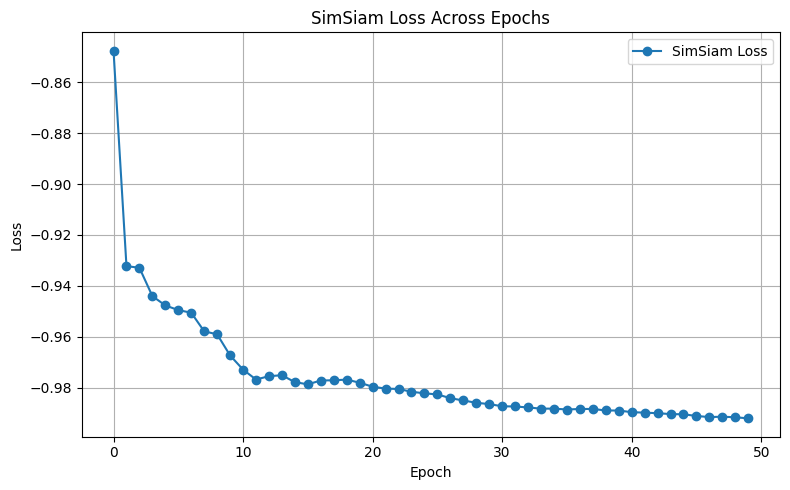

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(simsiam_loss_history, marker='o', label='SimSiam Loss')
plt.title("SimSiam Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
def visualize_simsiam_features(simsiam_model, data_path):
    dataset = EEGClassificationDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    simsiam_model.eval()
    encoder = simsiam_model.encoder
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to('cuda')
            feats = encoder(x).mean(dim=-1).cpu().numpy()  # shape: (B, emb_dim)
            all_feats.append(feats)
            all_labels.append(y.numpy())

    X = np.concatenate(all_feats)
    y = np.concatenate(all_labels)

    X_std = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_std)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="Set2")
    plt.title("t-SNE of SimSiam Encoder Representations")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

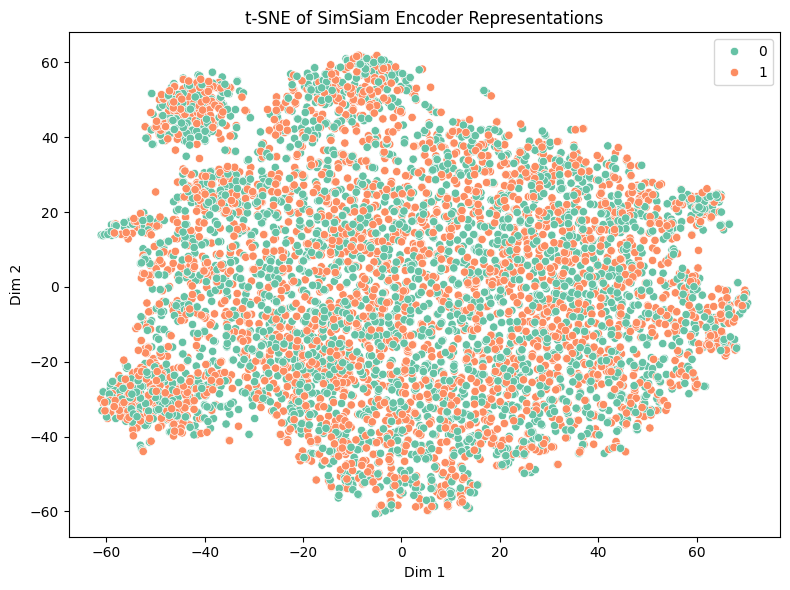

In [18]:
data_path = "preprocessed_epochs"
visualize_simsiam_features(simsiam_model, data_path)

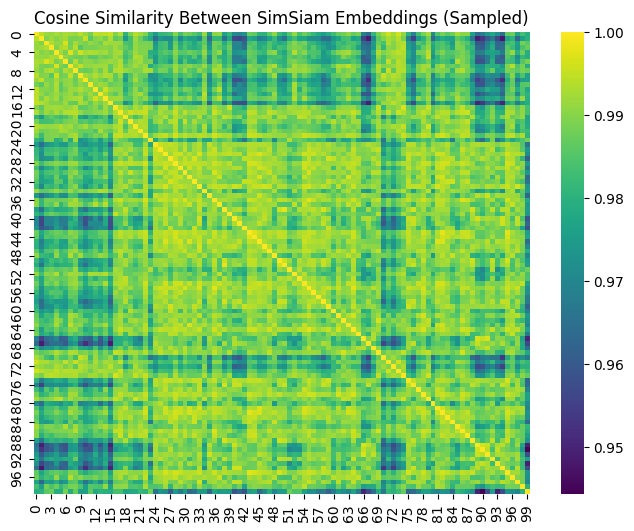

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

data_path = "preprocessed_epochs"
dataset = EEGClassificationDataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

#SimSiam Model
simsiam_model.eval()
#model.eval()
encoder = simsiam_model.encoder
all_feats, all_labels = [], []

with torch.no_grad():
    for x, y in dataloader:
        x = x.to('cuda')
        feats = encoder(x).mean(dim=-1).cpu().numpy()  # shape: (B, emb_dim)
        all_feats.append(feats)
        all_labels.append(y.numpy())

X = np.concatenate(all_feats)
y = np.concatenate(all_labels)

# Randomly sample 100 features
subset = X[:100]
sim_matrix = cosine_similarity(subset)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Cosine Similarity Between SimSiam Embeddings (Sampled)")
plt.show()

In [ ]:
#Fine-tuning and Linear Evaluation on SimSiam Encoder 

In [20]:
# Load encoder from the SimSiam model (trained earlier)
encoder = simsiam_model.encoder

encoder.eval()
encoder = encoder.to('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
#Linear Classification Head

class EEGLinearProbe(nn.Module):
    def __init__(self, encoder, emb_dim=128, n_classes=2):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # global pooling over time
            nn.Flatten(),
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):  # x: (B, C, T)
        z = self.encoder(x)  # (B, emb_dim, T)
        return self.head(z)  # (B, n_classes)

In [22]:
#Training Classifier

def train_eeg_classifier(model, dataloader, finetune=False, epochs=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    if not finetune:
        for p in model.encoder.parameters():
            p.requires_grad = False

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()

        acc = correct / len(dataloader.dataset)
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


In [23]:
# Dataset
dataset = EEGClassificationDataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model
finetune_model = EEGLinearProbe(encoder=encoder, emb_dim=128, n_classes=2)

# Train (set finetune=True to also update encoder)
train_eeg_classifier(finetune_model, dataloader, finetune=False, epochs=50)

[Epoch 1] Loss: 142.3551, Accuracy: 0.5002
[Epoch 2] Loss: 142.3127, Accuracy: 0.4951
[Epoch 3] Loss: 142.2156, Accuracy: 0.4934
[Epoch 4] Loss: 142.1547, Accuracy: 0.4959
[Epoch 5] Loss: 142.1791, Accuracy: 0.4930
[Epoch 6] Loss: 142.1316, Accuracy: 0.5008
[Epoch 7] Loss: 142.1501, Accuracy: 0.5018
[Epoch 8] Loss: 142.1774, Accuracy: 0.4939
[Epoch 9] Loss: 142.1438, Accuracy: 0.4974
[Epoch 10] Loss: 142.0812, Accuracy: 0.5076
[Epoch 11] Loss: 142.1269, Accuracy: 0.5021
[Epoch 12] Loss: 142.1348, Accuracy: 0.4922
[Epoch 13] Loss: 142.1179, Accuracy: 0.5008
[Epoch 14] Loss: 142.1268, Accuracy: 0.4979
[Epoch 15] Loss: 142.1326, Accuracy: 0.5011
[Epoch 16] Loss: 142.1259, Accuracy: 0.5006
[Epoch 17] Loss: 142.1135, Accuracy: 0.4972
[Epoch 18] Loss: 142.1191, Accuracy: 0.5028
[Epoch 19] Loss: 142.1085, Accuracy: 0.4965
[Epoch 20] Loss: 142.1152, Accuracy: 0.4956
[Epoch 21] Loss: 142.1248, Accuracy: 0.5000
[Epoch 22] Loss: 142.1071, Accuracy: 0.5066
[Epoch 23] Loss: 142.1221, Accuracy: 0.49

In [24]:
#Visualization of SimSiam Features

def tsne_visualize_encoder(encoder, data_path):
    dataset = EEGClassificationDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    encoder.eval()
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to('cuda')
            z = encoder(x).mean(dim=-1).cpu().numpy()
            all_feats.append(z)
            all_labels.append(y.numpy())

    X = np.concatenate(all_feats)
    y = np.concatenate(all_labels)

    X_std = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_std)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2')
    plt.title("t-SNE of SimSiam Encoder Representations")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

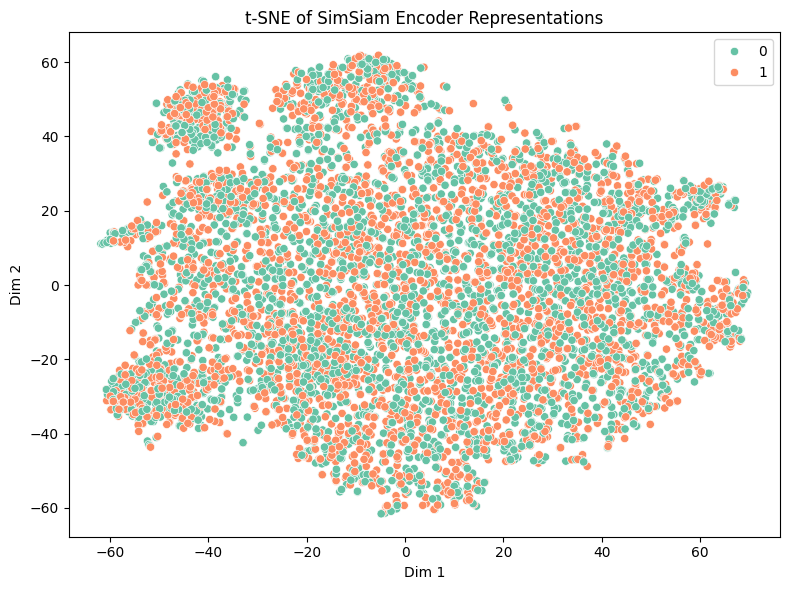

In [25]:
data_path = "preprocessed_epochs"
tsne_visualize_encoder(encoder, data_path)

In [ ]:
#Ablation Study: CNN Encoder vs. SimSiam Encoder

In [35]:
#Shared Classifier Wrapper

class EEGLinearClassifier(nn.Module):
    def __init__(self, encoder, emb_dim=128, n_classes=2):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        z = self.encoder(x)  # (B, emb_dim, T)
        return self.head(z)


In [36]:
#Shared Training and Evaluation Function

def evaluate_encoder(encoder, dataloader, finetune=False, epochs=10, name="Model"):
    model = EEGLinearClassifier(encoder, emb_dim=128, n_classes=2)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    if not finetune:
        for p in model.encoder.parameters():
            p.requires_grad = False

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        acc = correct / len(dataloader.dataset)
        print(f"[{name} Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


In [37]:
#Load both encoders

# Load Dataset
dataset = EEGClassificationDataset("preprocessed_epochs")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 🔵 Baseline MAE+SimCLR Encoder
encoder_baseline = CNNEncoder(in_channels=60, time_len=564)
baseline_ckpt = torch.load("cnn_encoder_output/pretrained_model.pth")
cnn_weights = {k.replace("encoder.encoder.", ""): v for k, v in baseline_ckpt.items() if k.startswith("encoder.encoder.")}
encoder_baseline.encoder.load_state_dict(cnn_weights)

# 🟢 SimSiam Encoder
encoder_simsiam = model.encoder  # from earlier SimSiam training


In [38]:
#Comparison

print("🔵 Evaluating Baseline (MAE + SimCLR)...")
evaluate_encoder(encoder_baseline, dataloader, finetune=False, name="Baseline")

print("\n🟢 Evaluating SimSiam...")
evaluate_encoder(encoder_simsiam, dataloader, finetune=False, name="SimSiam")


🔵 Evaluating Baseline (MAE + SimCLR)...
[Baseline Epoch 1] Loss: 142.3473, Accuracy: 0.5005
[Baseline Epoch 2] Loss: 142.2187, Accuracy: 0.5009
[Baseline Epoch 3] Loss: 142.2019, Accuracy: 0.5040
[Baseline Epoch 4] Loss: 142.2683, Accuracy: 0.4945
[Baseline Epoch 5] Loss: 142.1902, Accuracy: 0.4891
[Baseline Epoch 6] Loss: 142.2117, Accuracy: 0.4920
[Baseline Epoch 7] Loss: 142.1798, Accuracy: 0.5011
[Baseline Epoch 8] Loss: 142.1436, Accuracy: 0.5064
[Baseline Epoch 9] Loss: 142.1468, Accuracy: 0.4966
[Baseline Epoch 10] Loss: 142.1977, Accuracy: 0.4991

🟢 Evaluating SimSiam...
[SimSiam Epoch 1] Loss: 142.6162, Accuracy: 0.5009
[SimSiam Epoch 2] Loss: 142.2739, Accuracy: 0.4911
[SimSiam Epoch 3] Loss: 142.2524, Accuracy: 0.4989
[SimSiam Epoch 4] Loss: 142.1473, Accuracy: 0.5052
[SimSiam Epoch 5] Loss: 142.1902, Accuracy: 0.5087
[SimSiam Epoch 6] Loss: 142.1828, Accuracy: 0.4948
[SimSiam Epoch 7] Loss: 142.1299, Accuracy: 0.5011
[SimSiam Epoch 8] Loss: 142.1674, Accuracy: 0.4942
[SimSi

In [39]:
#t-SNE comparison

def plot_tsne(encoder, dataloader, name="Model"):
    encoder.eval()
    all_feats, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to('cuda')
            feats = encoder(x).mean(dim=-1).cpu().numpy()
            all_feats.append(feats)
            all_labels.append(y.numpy())

    X = np.concatenate(all_feats)
    y = np.concatenate(all_labels)

    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns
    import matplotlib.pyplot as plt

    X_std = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_std)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=y, palette="Set2")
    plt.title(f"t-SNE: {name} Encoder Representations")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.tight_layout()
    plt.show()


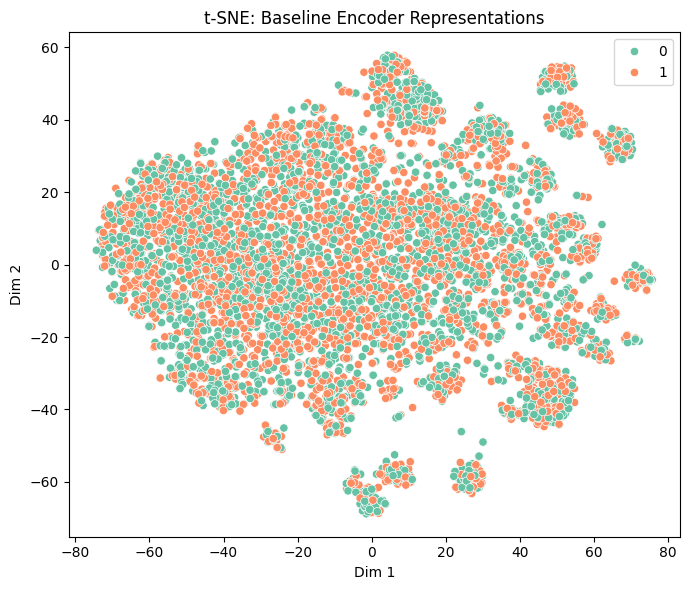

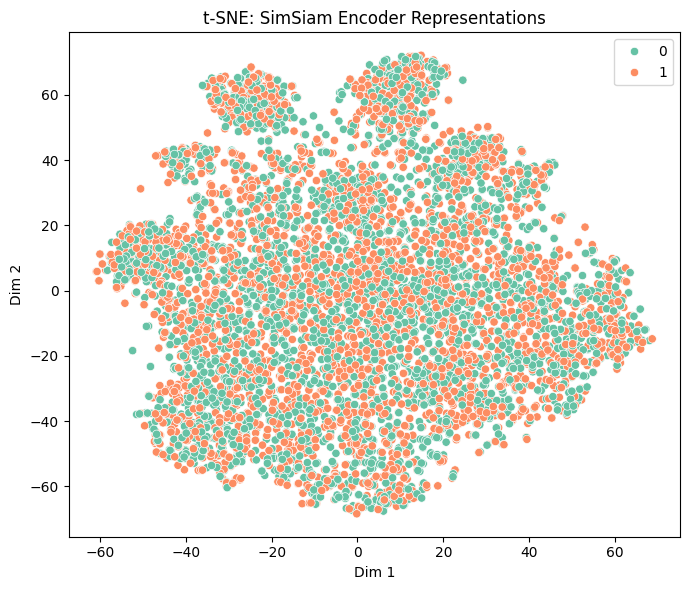

In [40]:
plot_tsne(encoder_baseline, dataloader, name="Baseline")
plot_tsne(encoder_simsiam, dataloader, name="SimSiam")

In [ ]:
#K-Means + GPT2 Classifier

In [26]:
#Extract SimSiam Encoder Features

encoder = simsiam_model.encoder  # already trained SimSiam encoder
encoder.eval()

data_path = "preprocessed_epochs"
all_features = []
all_labels = []

with torch.no_grad():
    for x, y in dataloader:
        x = x.to('cuda')
        z = encoder(x).mean(dim=-1).cpu().numpy()  # z ∈ ℝ^(B, emb_dim)
        all_features.append(z)
        all_labels.append(y.numpy())

X = np.vstack(all_features)  # shape: (N, emb_dim)
Y = np.concatenate(all_labels)  # shape: (N,)


In [27]:
#Run KMeans on feature vectors

from sklearn.cluster import KMeans

n_tokens = 256  # Vocabulary size
kmeans = KMeans(n_clusters=n_tokens, random_state=42).fit(X)

/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
#Convert feature sequences to token sequences

token_sequences = []

for z in all_features:          # z: (T', emb_dim)
    tokens = kmeans.predict(z)  # one token per EEG epoch, shape: (T',)
    #token_sequences.extend(tokens.tolist())
    token_sequences.append(tokens.tolist())  # one sequence per trial

In [31]:
#Save Token Sequences for GPT2 training

with open("gpt2_train_data.txt", "w") as f:
    for token, label in zip(token_sequences, Y):
        token_str = " ".join(map(str, tokens))  # e.g., "45 22 7 99 3 ..."
        f.write(f"{token_str}\t{label}\n")     # one line = full trial


In [28]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#GPT2 Training

In [32]:
#Load Dataset and Tokenizer

from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load dataset
dataset = load_dataset("text", data_files={"train": "gpt2_train_data.txt"})

# Load GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Add padding token since GPT2 doesn't have one

# Preprocess
def preprocess(example):
    token_str, label = example["text"].split("\t")
    inputs = tokenizer(token_str, truncation=True, padding="max_length", max_length=64)
    inputs["labels"] = int(label)
    return inputs

dataset = dataset.map(preprocess)

Generating train split: 0 examples [00:00, ? examples/s]

/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/205 [00:00<?, ? examples/s]

In [33]:
#Define GPT2 model for classification

from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
#Training arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2_eeg_classifier",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=20,
    save_steps=500,
    save_total_limit=1,
    evaluation_strategy="no"
)

In [34]:
pip show transformers

Name: transformers
Version: 4.36.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [35]:
pip show accelerate

Name: accelerate
Version: 1.8.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages
Requires: huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [32]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2_eeg_classifier",
    per_device_train_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=20,
    save_steps=500,
    save_total_limit=1,
    report_to=None,  # disable wandb/hub if you're not using them
)

# Remove dispatch_batches or other accelerator-specific flags if you've inherited/customized TrainingArguments


In [34]:
dispatch_batches = False
split_batches = False

In [35]:
#Train

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"]
)

trainer.train()

TypeError: __init__() got an unexpected keyword argument 'dispatch_batches'

In [34]:
#Manual Training Loop (No Trainer - Hugging Face)

from transformers import GPT2Tokenizer

class GPT2EEGDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=64):
        self.samples = []
        self.tokenizer = tokenizer
        with open(filepath, "r") as f:
            for line in f:
                token_str, label = line.strip().split("\t")
                input_ids = tokenizer(token_str, padding="max_length", truncation=True,
                                      max_length=max_length, return_tensors="pt")["input_ids"].squeeze()
                self.samples.append((input_ids, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [35]:
from sklearn.model_selection import train_test_split

with open("gpt2_train_data.txt", "r") as f:
    lines = f.readlines()

train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=42, stratify=[line.strip().split("\t")[1] for line in lines])

# Save train and test files
with open("gpt2_train.txt", "w") as f:
    f.writelines(train_lines)

with open("gpt2_test.txt", "w") as f:
    f.writelines(test_lines)

In [36]:
dataset = load_dataset("text", data_files={"train": "gpt2_train.txt", "test": "gpt2_test.txt"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [66]:
from transformers import GPT2ForSequenceClassification

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

train_dataset = GPT2EEGDataset("gpt2_train_data.txt", tokenizer)
loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#loss_fn = torch.nn.CrossEntropyLoss()

# Add class weights (inverse frequency)
class_counts = [3271, 3267]
weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for input_ids, labels in loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()

    acc = correct / len(dataset)
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Epoch 1] Loss: 591.0765, Accuracy: 1635.5000
[Epoch 2] Loss: 574.2801, Accuracy: 1612.5000
[Epoch 3] Loss: 572.8186, Accuracy: 1587.5000
[Epoch 4] Loss: 571.3661, Accuracy: 1607.0000
[Epoch 5] Loss: 570.6433, Accuracy: 1618.5000
[Epoch 6] Loss: 568.6753, Accuracy: 1674.0000
[Epoch 7] Loss: 568.3191, Accuracy: 1691.5000
[Epoch 8] Loss: 565.5445, Accuracy: 1746.5000
[Epoch 9] Loss: 563.0459, Accuracy: 1782.0000
[Epoch 10] Loss: 561.7137, Accuracy: 1814.5000


In [67]:
#Save model and tokenizer

model.save_pretrained("./gpt2_eeg_classifier2/final")
tokenizer.save_pretrained("./gpt2_eeg_classifier2/final")


('./gpt2_eeg_classifier2/final/tokenizer_config.json',
 './gpt2_eeg_classifier2/final/special_tokens_map.json',
 './gpt2_eeg_classifier2/final/vocab.json',
 './gpt2_eeg_classifier2/final/merges.txt',
 './gpt2_eeg_classifier2/final/added_tokens.json')

In [68]:
#Evaluate

from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

class GPT2EEGDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=64):
        self.samples = []
        self.tokenizer = tokenizer
        with open(filepath, "r") as f:
            for line in f:
                token_str, label = line.strip().split("\t")
                input_ids = tokenizer(token_str, padding="max_length", truncation=True,
                                      max_length=max_length, return_tensors="pt")["input_ids"].squeeze()
                self.samples.append((input_ids, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

✅ Accuracy: 0.5657

📋 Classification Report:
               precision    recall  f1-score   support

     Class 0       0.58      0.49      0.53       654
     Class 1       0.56      0.65      0.60       654

    accuracy                           0.57      1308
   macro avg       0.57      0.57      0.56      1308
weighted avg       0.57      0.57      0.56      1308



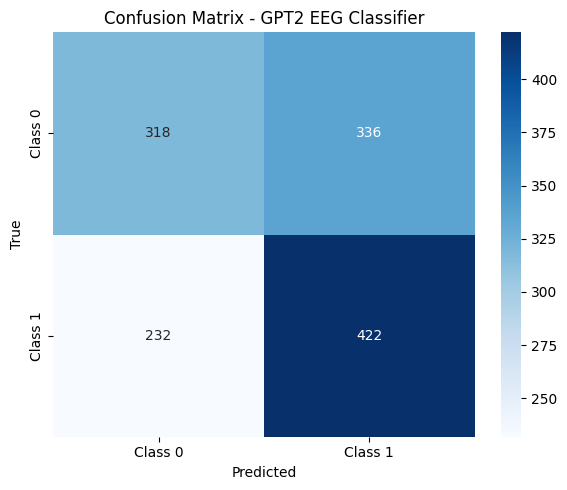

In [69]:
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained("./gpt2_eeg_classifier2/final")
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load evaluation dataset
test_dataset = GPT2EEGDataset("gpt2_test.txt", tokenizer)  # same file, or replace with a test split
dataloader = DataLoader(test_dataset, batch_size=8)

# Inference
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
cm = confusion_matrix(all_labels, all_preds)

print(f"✅ Accuracy: {accuracy:.4f}")
print("\n📋 Classification Report:\n", report)

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GPT2 EEG Classifier")
plt.tight_layout()
plt.show()

In [37]:
#Train longer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

train_dataset = GPT2EEGDataset("gpt2_train_data.txt", tokenizer)
loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#loss_fn = torch.nn.CrossEntropyLoss()

# Add class weights (inverse frequency)
class_counts = [3271, 3267]
weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

for epoch in range(50):
    model.train()
    total_loss, correct = 0, 0
    for input_ids, labels in loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()

    acc = correct / len(dataset)
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


[Epoch 1] Loss: 36.6986, Accuracy: 44.0000
[Epoch 2] Loss: 19.2522, Accuracy: 52.0000
[Epoch 3] Loss: 18.4995, Accuracy: 52.5000
[Epoch 4] Loss: 18.4842, Accuracy: 52.0000
[Epoch 5] Loss: 18.8526, Accuracy: 49.5000
[Epoch 6] Loss: 18.6178, Accuracy: 47.5000
[Epoch 7] Loss: 18.4692, Accuracy: 48.5000
[Epoch 8] Loss: 18.7146, Accuracy: 48.5000
[Epoch 9] Loss: 19.0203, Accuracy: 53.0000
[Epoch 10] Loss: 18.5628, Accuracy: 52.5000
[Epoch 11] Loss: 18.2469, Accuracy: 52.0000
[Epoch 12] Loss: 18.4273, Accuracy: 52.0000
[Epoch 13] Loss: 17.7979, Accuracy: 58.0000
[Epoch 14] Loss: 19.4514, Accuracy: 49.0000
[Epoch 15] Loss: 18.7060, Accuracy: 44.5000
[Epoch 16] Loss: 18.2325, Accuracy: 55.0000
[Epoch 17] Loss: 18.8152, Accuracy: 46.0000
[Epoch 18] Loss: 19.6051, Accuracy: 50.0000
[Epoch 19] Loss: 18.6382, Accuracy: 49.5000
[Epoch 20] Loss: 18.5193, Accuracy: 54.5000
[Epoch 21] Loss: 18.5383, Accuracy: 45.5000
[Epoch 22] Loss: 18.4718, Accuracy: 51.0000
[Epoch 23] Loss: 18.3770, Accuracy: 51.00

In [38]:
model.save_pretrained("./gpt2_eeg_classifier3/final")
tokenizer.save_pretrained("./gpt2_eeg_classifier3/final")

('./gpt2_eeg_classifier3/final/tokenizer_config.json',
 './gpt2_eeg_classifier3/final/special_tokens_map.json',
 './gpt2_eeg_classifier3/final/vocab.json',
 './gpt2_eeg_classifier3/final/merges.txt',
 './gpt2_eeg_classifier3/final/added_tokens.json')

In [39]:
class GPT2EEGDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=64):
        self.samples = []
        self.tokenizer = tokenizer
        with open(filepath, "r") as f:
            for line in f:
                token_str, label = line.strip().split("\t")
                input_ids = tokenizer(token_str, padding="max_length", truncation=True,
                                      max_length=max_length, return_tensors="pt")["input_ids"].squeeze()
                self.samples.append((input_ids, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/e19249/miniconda3/

✅ Accuracy: 0.5122

📋 Classification Report:
               precision    recall  f1-score   support

     Class 0       0.51      1.00      0.68        21
     Class 1       0.00      0.00      0.00        20

    accuracy                           0.51        41
   macro avg       0.26      0.50      0.34        41
weighted avg       0.26      0.51      0.35        41



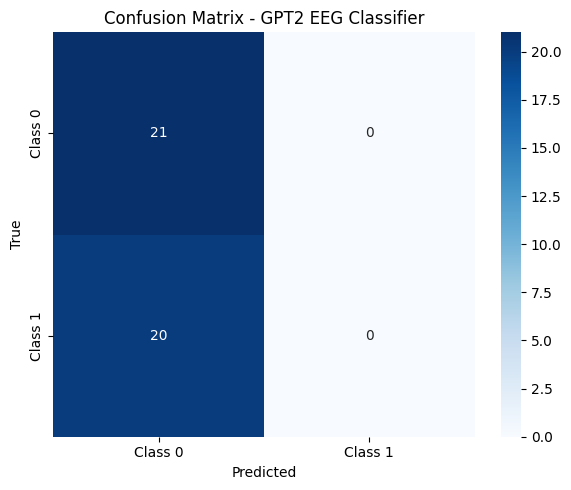

In [41]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained("./gpt2_eeg_classifier2/final")
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load evaluation dataset
test_dataset = GPT2EEGDataset("gpt2_test.txt", tokenizer)  # same file, or replace with a test split
dataloader = DataLoader(test_dataset, batch_size=8)

# Inference
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
cm = confusion_matrix(all_labels, all_preds)

print(f"✅ Accuracy: {accuracy:.4f}")
print("\n📋 Classification Report:\n", report)

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GPT2 EEG Classifier")
plt.tight_layout()
plt.show()